# Assignment 5
## Decision Trees and Random Forests for Regression, Part 2

### About this notebook

The general description and instructions as well as questions for the work with Part 2 of the assignment (this notebook) are found in the Assignment description in Canvas!


In [1]:
# YOU DON'T HAVE TO RUN THIS IF EVERYTHING IS ALREADY INSTALLED CORRECTLY
#!pip3 install --upgrade pip
#!pip3 install graphviz
#!pip3 install dtreeviz
#!pip3 install numpy scipy
#!pip3 install ordered_set

## Dataset(s)

**Step 0:** First load the dataset you want to use. Ultimately, you should be working with the **California housing data**, but for quicker test runs, it might help to first start out with the Diabetes data. For an initial test that your implementation actually works correctly, you should use the **ConceptData**.

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
import graphviz
import importlib

#from lab5.ID3_reg import ID3RegressionTreePredictor

#importlib.reload(ID3RegressionTreePredictor)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#test_case = 'concept'
test_case = 'california'
#test_case = 'diabetes'

if test_case == 'california':
    dataset = fetch_california_housing()
elif test_case == 'diabetes':
    dataset = load_diabetes()
elif test_case == 'concept':
    print("running on toy data, actual data will be loaded later")
else:
    raise ValueError('Unknown test case')



If using real data, split the set into train, validation and test sets.

In [3]:
if (test_case == 'california') or (test_case == 'diabetes'):
    X = dataset.data
    y = dataset.target

    train_ratio = 0.70
    validation_ratio = 0.15
    test_ratio = 0.15
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0)
    

## Creating and evaluating an ID3-based Regression Tree

The following cells provide some framework for creating / testing your own, ID3-based, regressor. To see that your tree is constructed correctly, some prints are provided (essentially from the lecture) within the handout directory, that are created with the "ConceptData" from the lecture. 

**Step 1:** To make experiments with categorical data, you need to discretize - bin - the data (this goes both for the 'california' and the 'diabetes' cases, for the toy data - 'concept' - case, this is naturally given, note that the data are only loaded below). 
In order to have the entire data set "as is" for the binning, you can prepare a binning rule on the original data (X), that you then apply to your train and test data sets. To make sure that you do not miss any possible attribute values, use the entire set (X) again when providing the categorical values (here bin indices) to the ID3 tree.

In [4]:
from ConceptDataRegr import ConceptDataRegr
import ConceptDataRegr as cd

from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

# For testing that you get the correct output from your own implementation, use the "ConceptData" data set:
if test_case == 'concept' :
    attributes, binned_X_train, y_train, binned_X_test, y_test = cd.ConceptDataRegr().get_data()
    binned_X_val = []
    y_val = []
     
else :
    # you might want to try different numbers of bins
    # inspect the data set description in part 1 to find suitable numbers 
    if test_case == 'california':
        #bins = [2,2,2,2,2,2,2,2]
        #bins = [5,5,5,5,5,5,5,5]
        bins = [8,8,8,8,8,8,8,8]
    elif test_case == 'diabetes':
        #bins = [2,2,2,2,2,2,2,2,2,2]
        bins = [5,5,5,5,5,5,5,5,5,5]
        
    # here you can test to use different strategies, see the KBinsDiscretizer documentation
    binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    binning_rule = binner.fit(X)
    # use the binning rule
    binned_X = binning_rule.transform(X).astype(int)
    binned_X_train = binning_rule.transform(X_train).astype(int)
    binned_X_val = binning_rule.transform(X_val).astype(int)
    binned_X_test = binning_rule.transform(X_test).astype(int)

    # create an attribute list with "conceptual" features/attributes
    attributes = {}
    i = 0
    for attr in dataset.feature_names :
        attributes[attr] = set(binned_X[:,i])
        i+=1

print(attributes)

{'MedInc': {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}, 'HouseAge': {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}, 'AveRooms': {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}, 'AveBedrms': {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}, 'Population': {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}, 'AveOccup': {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}, 'Latitude': {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}, 'Longitude': {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}}


**Step 2:** Set up and fit the tree, create the dot-data for visualisation. Fill the stubbs for *findSplitAttr*, *calcMSE*, and *score* in *ID3_reg.py* and compare results against the sklearn implementation using different parameters for *max_depth* and *min_samples_leaf*

In [6]:
import ID3_reg

# Now, set up the tree (inspect the ID3_reg class!)    
id3 = ID3_reg.ID3RegressionTreePredictor()

# visualising in the "bubble" format from the lecture
myTree = id3.fit(binned_X_train, y_train, attributes)

dot_data = id3.makeDotData().source
graph = graphviz.Source(dot_data, format="pdf")
graph.render(test_case+"_bubbles")
graph

ModuleNotFoundError: No module named 'ordered_set'

Do a prediction and scoring on the binned valuation and / or test data

In [45]:
predicted = id3.predict(binned_X_val)
print(predicted)

# As of now, the ID3_reg class does only provide a stubb of a score-method - please implement one according to
# the description of DecisionTreeRegressor.score() for easier comparison with the scikit-learn trees!
id3.score(binned_X_test, y_test)

[2.1741190476190475, 2.506616666666667, 1.3702727272727275, 2.793654186746988, 1.623579646017699, 1.1762833333333333, 1.831967608695652, 2.4909354838709685, 1.623579646017699, 1.683673469387755, 2.839435647668394, 0.6784230769230769, 2.923066685082872, 1.91, 2.506616666666667, 3.5934387341772154, 2.941051847133758, 2.1140606060606064, 1.7329851879699247, 1.956375, 2.839435647668394, 1.4670303030303027, 2.941051847133758, 2.521333333333333, 1.623579646017699, 1.4027777777777777, 2.4021600000000003, 2.424557759562841, 2.0250625, 1.7329851879699247, 1.3714457608695652, 1.9236, 1.7113846153846155, 2.610655119047619, 3.2145914935064934, 1.97567525, 1.623579646017699, 1.5508660714285714, 1.6713898305084744, 1.3702727272727275, 2.839435647668394, 2.701253968253968, 2.923066685082872, 2.2208014102564104, 1.3231632653061227, 3.2546404, 2.923066685082872, 2.1290540540540532, 1.5686666666666669, 2.1975977011494257, 0.71625, 2.555655231316726, 1.623579646017699, 2.941051847133758, 2.36366145161290

0.5814007290265235

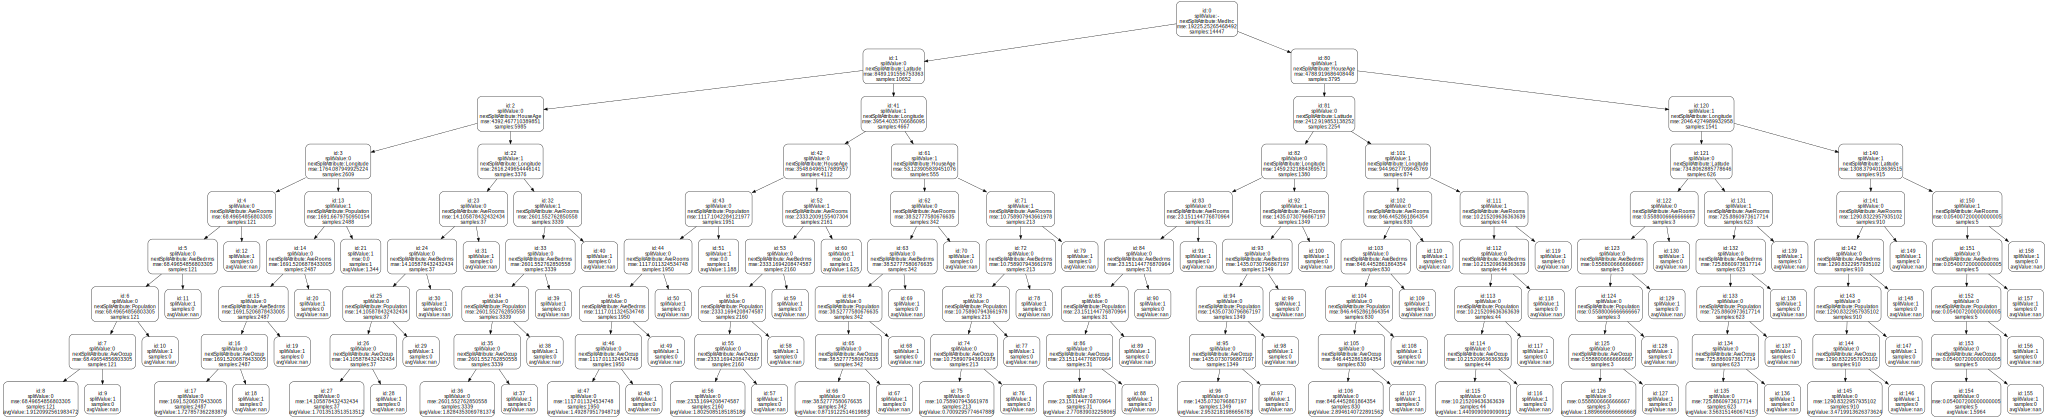

In [23]:
# printing to squares if you want a tree that looks more like those from part 1 ;-)
dot_data_pretty='digraph Tree {\n'+\
    'node [shape=box'+\
    ', style="rounded", color="black"'+\
    ', fontname="helvetica"] ;\n'+\
    'graph [ranksep=equally, splines=polyline] ;\n'+\
    'edge [fontname="helvetica"] ;\n'+\
    dot_data[9:]

graph = graphviz.Source(dot_data_pretty, format="png")
graph.render(test_case+"_pretty")
#graph.view()
graph

# ANSWER TABLE

1.0 is perfect score

2 bins
- diabetes -0.596047194406232
- californa 0.35140614724235586

5 bins
- diabetes: 1.3128414302854234
- californa: 0.5814007290265235    

Max Depth: 1
Score: 0.2958635051924463

Max Depth: 10
Score: 0.6812220641961471

Min_Sample_Leaf: 1
Score: 0.5952096212035327

Min_sample_leaf: 20
Score: 0.7159977936230865
